In [11]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

In [12]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [13]:
def GenerateRawData(filePath):    
    Feature = pd.read_csv('GSC-Features.csv', index_col=False)
    Samepair = pd.read_csv('same_pairs.csv')
    Samepair = Samepair.sample(10000)
    data = pd.merge(left=Samepair, right=Feature, left_on='img_id_A', right_on='img_id')
    newdata = pd.merge(left=data, right=Feature, left_on='img_id_B', right_on='img_id')   
    newdata = newdata.drop(['img_id_A','img_id_B'], axis = 1)
    print(newdata.shape)

    Feature = pd.read_csv('GSC-Features.csv', index_col=False)
    Diffpair = pd.read_csv('diffn_pairs.csv')
    Diffpair = Diffpair.sample(10000)
    data = pd.merge(left=Diffpair, right=Feature, left_on='img_id_A', right_on='img_id')
    newdata1 = pd.merge(left=data, right=Feature, left_on='img_id_B', right_on='img_id')
    newdata1 = newdata1.drop(['img_id_A','img_id_B'], axis = 1)
    print(newdata1.shape)

    frames = [newdata, newdata1]
    Hdata = pd.concat(frames)
    Hdatanew = shuffle(Hdata)
    print(Hdatanew.shape)
    t = Hdatanew['target']
    t = t.as_matrix()
    Hdata2 = Hdatanew.drop(['target'], axis = 1)
    Hdata2 = Hdata2.loc[:, ~Hdata2.columns.str.contains('^img_id')]
    uniques = Hdata2.apply(lambda x: x.nunique())
    Hdata3 = Hdata2.drop(uniques[uniques==1].index, axis=1)
    dataMatrix = Hdata3.as_matrix()
    dataMatrix = np.transpose(dataMatrix)
    return dataMatrix,t

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.pinv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [14]:
RawData, RawTarget = GenerateRawData('GSC-Features.csv')
print(RawData.shape)
print(RawTarget.shape)

(10000, 1027)
(10000, 1027)
(20000, 1027)


C:\Users\sagni\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(1016, 20000)
(20000,)


C:\Users\sagni\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [15]:
# RawTarget = GetTargetVector(RawData)
# print(len(RawTarget))

## Prepare Training Data

In [16]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(16000,)
(1016, 16000)


## Prepare Validation Data

In [17]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(1999,)
(1016, 1999)


## Prepare Test Data

In [18]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(1999,)
(1016, 1999)


## Finding Erms on training, validation and test set 

In [19]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

## Gradient Descent solution for Linear Regression

In [20]:
W_Now        = np.ones(M,dtype = int)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
index        = []

for i in range(0,800):
    
    index.append(i)
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    W_now1 = np.transpose(W_Now)
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [21]:
print ('----------Gradient Descent Solution--------------------')
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
E_rms Training   = 0.55253
E_rms Validation = 0.55582
E_rms Testing    = 0.54671


C:\Users\sagni\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """Entry point for launching an IPython kernel.


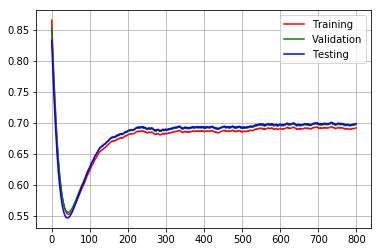

In [22]:
plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])
plt.grid()
plt.plot(index, L_Erms_TR)
plt.plot(index, L_Erms_Val)
plt.plot(index, L_Erms_Test)
plt.legend(['Training', 'Validation', 'Testing'], loc='upper right')